<a href="https://colab.research.google.com/github/mqc25/Cell_count/blob/master/DeterminePeaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
Determine Centroid Location

'''


### Imports
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import imageio

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle


In [2]:
'''
Data directories
'''

use_google_colab = 1 #toggle COLAB setup 
if (use_google_colab == 1):
    ############################################################################
    # Read Data from google drive
    ############################################################################
    from google.colab import drive #for loading gdrive data
    drive.mount('/content/gdrive')

    ###                     MAIN DIRECTORY NAMES
    gdir = '/content/gdrive/My Drive/'
    main_directory = gdir


    truth_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','ground_truth')
    prediction_dir = os.path.join(gdir,'BE224B_2020','SAMPLE_DATA','prediction')


else:
    ############################################################################
    # Read Data from local drive
    ############################################################################
    print('INSERT LOCAL DRIVE INFO')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
'''
Get truth data information

'''
truth_list = os.listdir(truth_dir)

#read in csv data and store in a dictionary
csv_data ={}
for cname in truth_list:
    filename = os.path.join(truth_dir,cname)
    root_ext = os.path.splitext(cname) #will return two parts, name and ext
    short_name=root_ext[0]
    with open(filename) as csvfile:
        csv_data[short_name]=[]
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader, None)  # skip the header
        for row in csv_reader:
            #if line_count == 0:
            csv_data[short_name].append(np.array(row,dtype=float))

In [0]:
'''
Get Prediction information

'''
prediction_list = os.listdir(prediction_dir)

#read in csv data and store in a dictionary
p_data ={}
for pname in prediction_list:
    filename = os.path.join(prediction_dir,pname)
    root_ext = os.path.splitext(pname) #will return two parts, name and ext
    short_name=root_ext[0]
    with open(filename) as csvfile:
        p_data[short_name]=[]
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader, None)  # skip the header
        for row in csv_reader:
            #if line_count == 0:
            p_data[short_name].append(np.array(row,dtype=float))


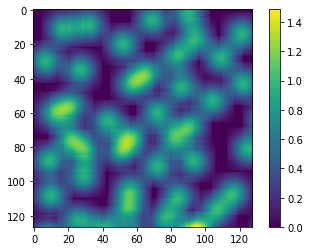

In [5]:
plt.imshow(csv_data['y_true_120'])
plt.colorbar()

(127, 128)
(127, 128)
coordinates:  [[121  77]
 [116 107]
 [113  55]
 [110  84]
 [109  56]
 [108 115]
 [108  10]
 [ 94  29]
 [ 91  72]
 [ 87  93]
 [ 87   9]
 [ 79  26]
 [ 77  54]
 [ 72  84]
 [ 65  43]
 [ 60  72]
 [ 58  17]
 [ 53 104]
 [ 45  86]
 [ 43 122]
 [ 40  62]
 [ 40  61]
 [ 35  27]
 [ 30   7]
 [ 28 109]
 [ 26  84]
 [ 20  52]
 [ 18  93]
 [ 14 121]
 [ 11  20]
 [  9  29]
 [  6  69]]


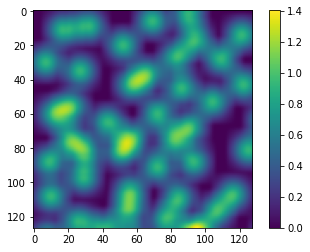

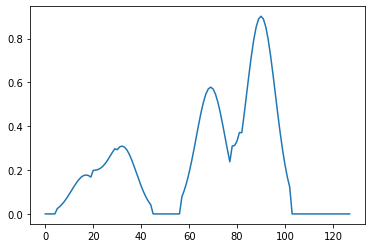

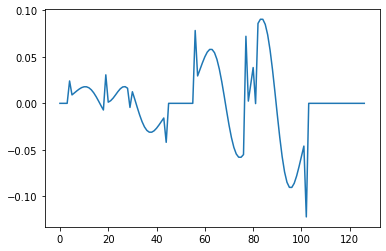

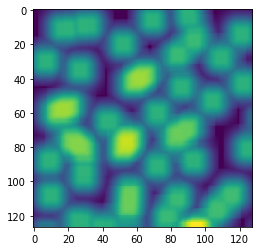

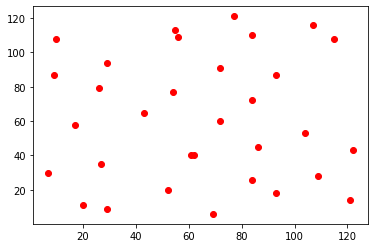

In [6]:
from scipy.ndimage import gaussian_filter, laplace
image = csv_data['y_true_120']
dv = np.gradient(csv_data['y_true_120'])

idv = gaussian_filter(image, sigma=1)

plt.imshow(idv)
plt.colorbar()

print(np.shape(csv_data['y_true_120']))
print(np.shape(image))

row = image[0][:]

plt.figure()
plt.plot(row)

d1 = np.diff(row)
plt.figure()
plt.plot(d1)


from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
image1 = img_as_float(image)
image_max = ndi.maximum_filter(image1, size=5, mode='constant')

plt.figure()
plt.imshow(image_max)

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(image1, min_distance=5)
print('coordinates: ',coordinates)


plt.figure()
for ii in coordinates:
    row = ii[0]
    col = ii[1]
    plt.plot(col,row,'ro')

In [0]:
def get_cross(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol

    #print(lowrow,highrow,lowcol,highcol)
    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]

    return row_data,col_data


In [0]:
def get_square(data_in, row, col,dlength):
    #get a cross of data to test
    lowrow = row-dlength
    highrow = row + dlength
    lowcol = col - dlength
    highcol = col + dlength

    #get border limits
    nrow,ncol = np.shape(data_in)

    if ( (row - dlength ) < 0):
        #return a smaller value
        lowrow = 0
    if ( (row + dlength ) > nrow):
        #return a smaller value
        highrow = nrow
    if ( (col- dlength ) < 0):
        #return a smaller value
        lowcol = 0
    if ( (col + dlength ) > ncol):
        #return a smaller value
        highcol = ncol

    #print(lowrow,highrow,lowcol,highcol)
    row_data = data_in[lowrow:highrow,col]
    col_data = data_in[row,lowcol:highcol]

    submatrix = data[lowrow:highrow,lowcol:highcol]
    return submatrix

Now running on Truth Data:  y_true_120


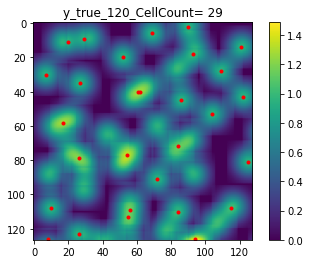

Now running on Truth Data:  y_true_121


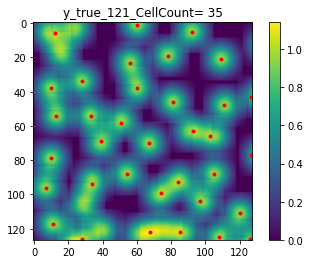

Now running on Truth Data:  y_true_124


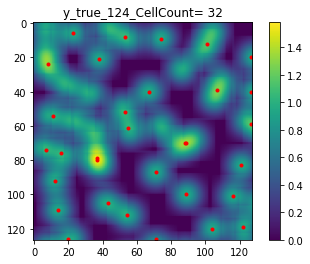

Now running on Truth Data:  y_true_122


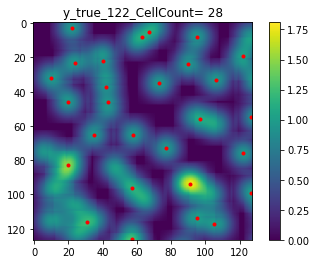

Now running on Truth Data:  y_true_123


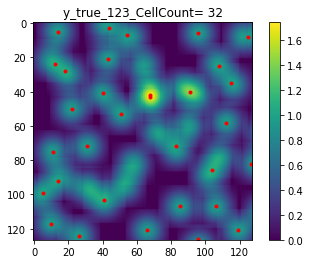

Now running on Truth Data:  y_true_126


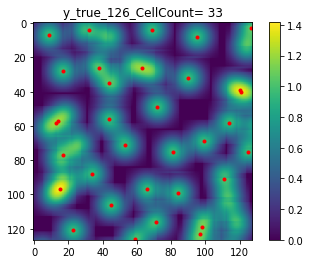

Now running on Truth Data:  y_true_125


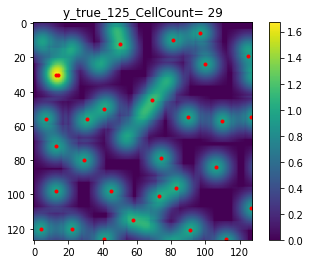

Now running on Truth Data:  y_true_129


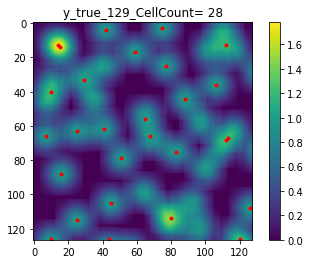

Now running on Truth Data:  y_true_128


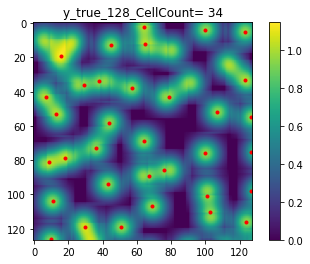

Now running on Truth Data:  y_true_130


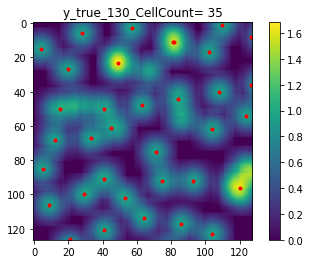

Now running on Truth Data:  y_true_127


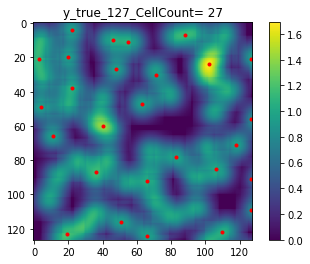

Now running on Truth Data:  y_true_132


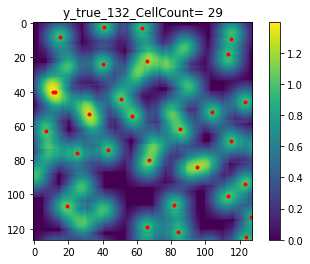

Now running on Truth Data:  y_true_131


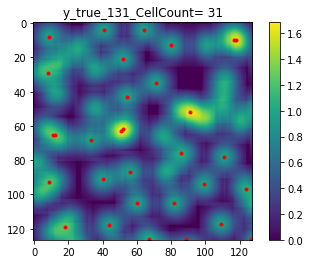

Now running on Truth Data:  y_true_133


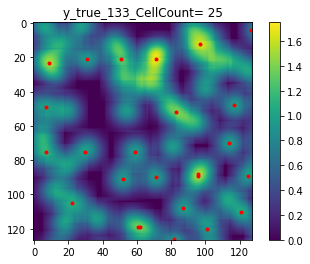

Now running on Truth Data:  y_true_134


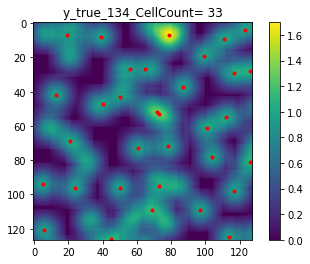

Now running on Truth Data:  y_true_136


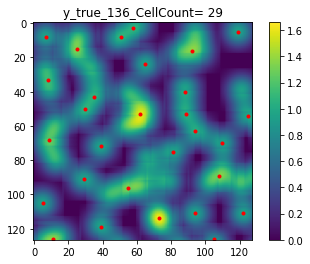

Now running on Truth Data:  y_true_135


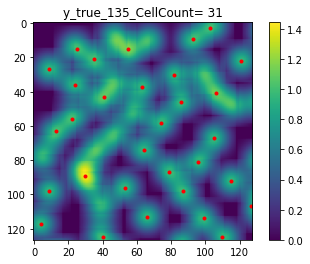

Now running on Truth Data:  y_true_139


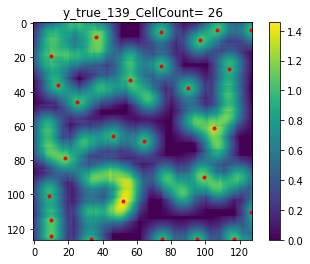

Now running on Truth Data:  y_true_138


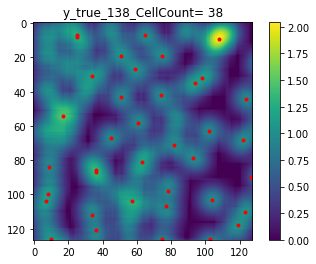

Now running on Truth Data:  y_true_137


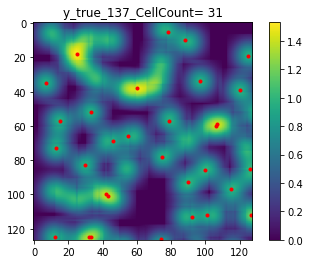

Now running on Truth Data:  y_true_141


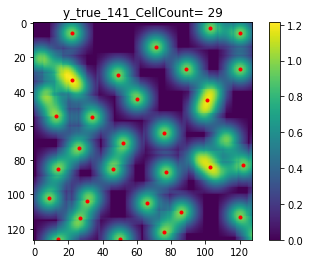

Now running on Truth Data:  y_true_140


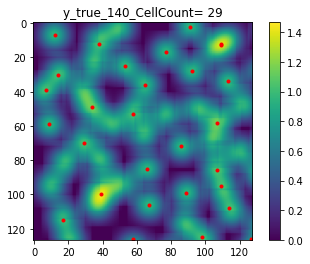

Now running on Truth Data:  y_true_142


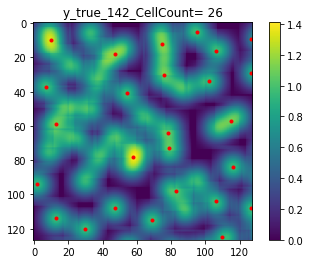

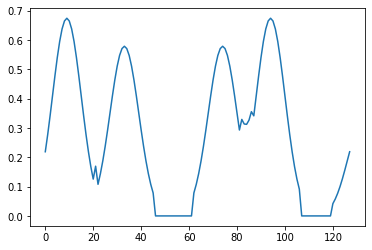

In [31]:
box_width = 11 #pixels
min_threshold = 0.25
for fname in csv_data.keys():
    print('Now running on Truth Data: ',fname)
    data = np.asmatrix(csv_data[fname])
    nr,nc = np.shape(data)
#data = np.asmatrix(csv_data['y_true_120'])
    peak_counter = 0
    peak_points ={}
    for row in range(0,nr):
        peak_points[row]=[]
        for col in range(0,nc):
            if (row >= 0) and (col >=0):
                '''
                rdata,cdata = get_cross(data,row,col, 11)
                #subm = get_square(data,row,col, 11) #box around point
                if (data[row,col] >= np.max(rdata)) and (data[row,col] >= np.max(cdata)) :
                    #remove any points hovering around background values
                    if (data[row,col] > (np.max(data)*0.2)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    continue
                '''
                subm = get_square(data,row,col, box_width) #box around point
                if (data[row,col] >= np.matrix.max(subm)):
                    #remove any points hovering around background values
                    if (data[row,col] > ( (np.matrix.max(data)) * min_threshold)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    #print(data[row,col], np.max(subm))
                    continue

    #print(np.shape(peak_points))

    plt.imshow(csv_data[fname])
    plt.colorbar()
    for ii in peak_points.keys():
        for jj in peak_points[ii]:
            x=jj
            y=ii
            if (ii == 0):
                mark = 'r.' #use to test special points, if needed
            else:
                mark = 'r.'
            plt.plot(x,y,mark)
    tname = fname + '_' + 'CellCount= ' + str(peak_counter)
    plt.title(tname)
    plt.show()


plt.figure()
f = np.array(data)
plt.plot(f[0,:])

In [27]:
data[0:5,0:5]
print(np.shape(subm))
print(np.max(subm))
print(np.matrix.max(data))

(6, 6)
0.5782945799334971
1.410696340237736


Now running on Prediction:  y_pred_120


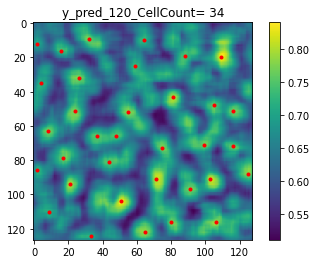

Now running on Prediction:  y_pred_121


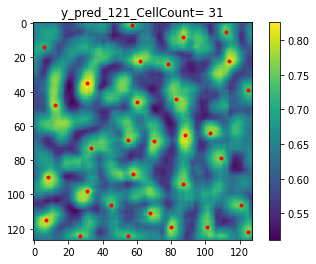

Now running on Prediction:  y_pred_122


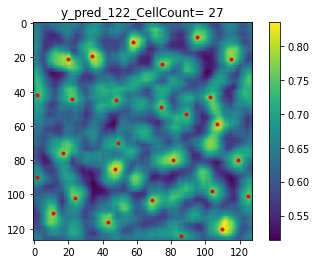

Now running on Prediction:  y_pred_123


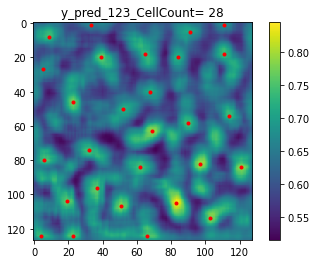

Now running on Prediction:  y_pred_124


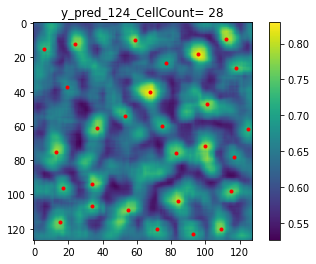

Now running on Prediction:  y_pred_125


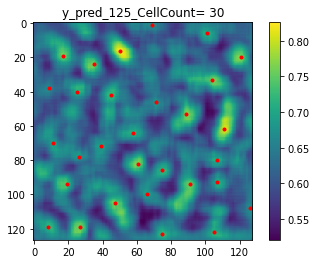

Now running on Prediction:  y_pred_126


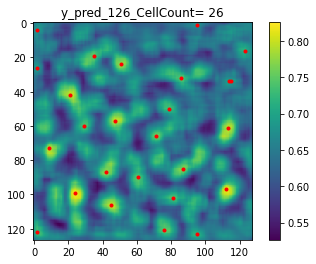

Now running on Prediction:  y_pred_128


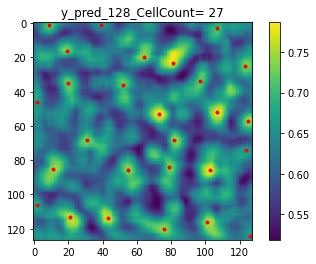

Now running on Prediction:  y_pred_129


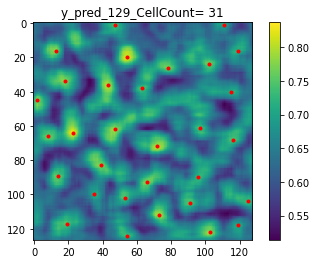

Now running on Prediction:  y_pred_127


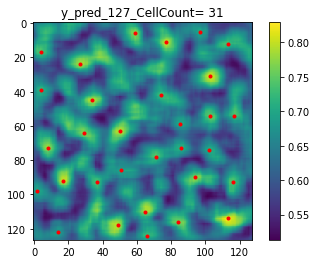

Now running on Prediction:  y_pred_130


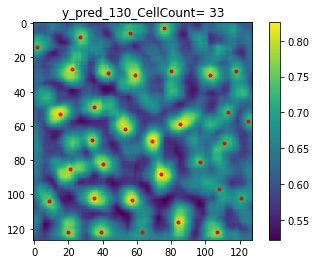

Now running on Prediction:  y_pred_131


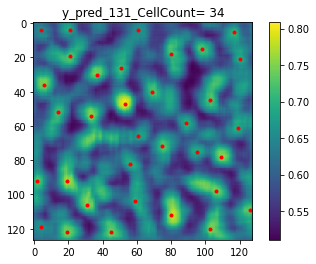

Now running on Prediction:  y_pred_133


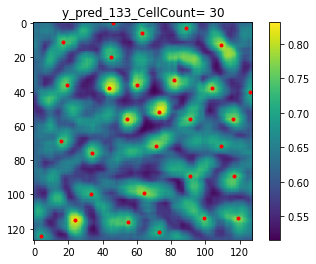

Now running on Prediction:  y_pred_132


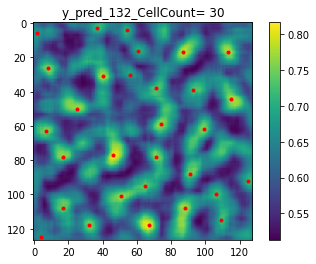

Now running on Prediction:  y_pred_135


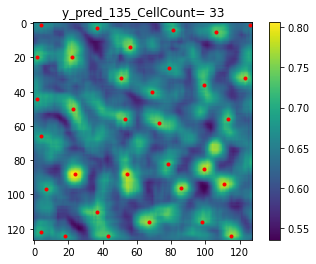

Now running on Prediction:  y_pred_136


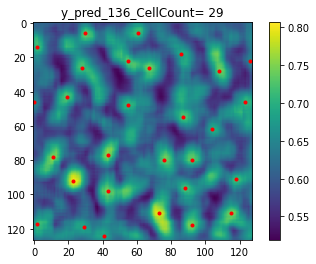

Now running on Prediction:  y_pred_134


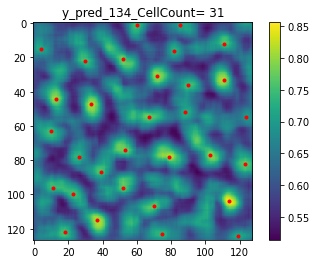

Now running on Prediction:  y_pred_137


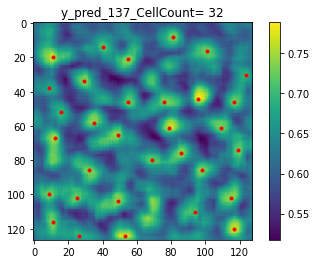

Now running on Prediction:  y_pred_139


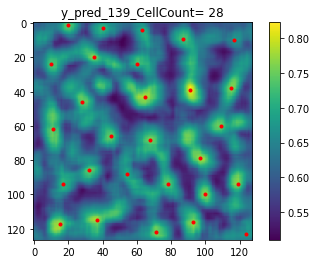

Now running on Prediction:  y_pred_138


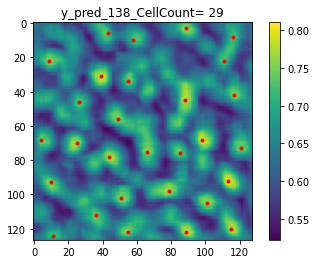

Now running on Prediction:  y_pred_141


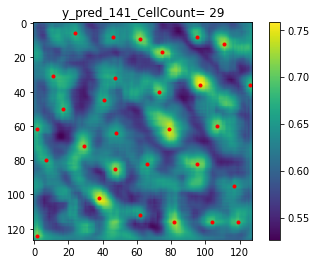

Now running on Prediction:  y_pred_142


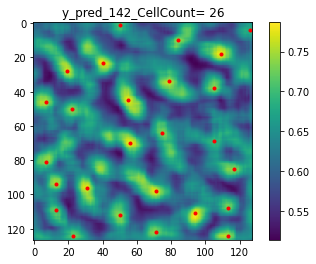

Now running on Prediction:  y_pred_140


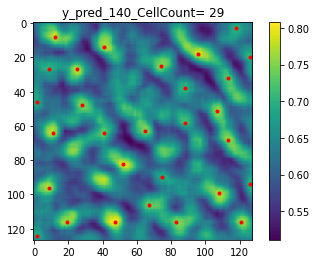

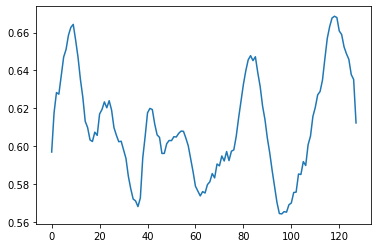

In [32]:
for fname in p_data.keys():
    print('Now running on Prediction: ',fname)
    data = np.asmatrix(p_data[fname])
    nr,nc = np.shape(data)
#data = np.asmatrix(csv_data['y_true_120'])
    peak_counter = 0
    peak_points ={}
    for row in range(0,nr):
        peak_points[row]=[]
        for col in range(0,nc):
            if (row >= 0) and (col >=0):
                '''
                rdata,cdata = get_cross(data,row,col, 5)
                if (data[row,col] >= np.max(rdata)) and (data[row,col] >= np.max(cdata)) :
                    #remove any points hovering around background values
                    if (data[row,col] > (np.max(data)*0.2)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    continue
                '''
                subm = get_square(data,row,col, box_width) #box around point
                if (data[row,col] >= np.matrix.max(subm)):
                    #remove any points hovering around background values
                    if (data[row,col] > ( (np.matrix.max(data)) * min_threshold)):
                        peak_points[row].append(col)
                        peak_counter = peak_counter + 1
                else:
                    #print(data[row,col], np.max(subm))
                    continue

    #print(np.shape(peak_points))

    plt.imshow(p_data[fname])
    plt.colorbar()
    for ii in peak_points.keys():
        for jj in peak_points[ii]:
            x=jj
            y=ii
            if (ii == 0):
                mark = 'r.' #alternative marker for testing
            else:
                mark = 'r.'
            plt.plot(x,y,mark)
    tname = fname + '_' + 'CellCount= ' + str(peak_counter)
    plt.title(tname)
    plt.show()


plt.figure()
f = np.array(data)
plt.plot(f[0,:])

In [0]:
peak_points[]

{0: [54],
 1: [],
 2: [],
 3: [118],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [12, 57, 85],
 9: [],
 10: [87],
 11: [],
 12: [],
 13: [89],
 14: [41],
 15: [44],
 16: [],
 17: [97],
 18: [96],
 19: [],
 20: [47, 126],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [74],
 26: [],
 27: [9, 25],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [58, 113],
 33: [],
 34: [],
 35: [],
 36: [49],
 37: [],
 38: [88, 114],
 39: [89],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [50, 119],
 45: [],
 46: [2],
 47: [],
 48: [28, 65],
 49: [],
 50: [53],
 51: [107],
 52: [],
 53: [59],
 54: [74],
 55: [],
 56: [39],
 57: [],
 58: [23, 62, 88, 110, 126],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [65],
 64: [11, 41],
 65: [],
 66: [],
 67: [33],
 68: [97, 113],
 69: [],
 70: [],
 71: [],
 72: [116],
 73: [],
 74: [23, 76],
 75: [],
 76: [3],
 77: [],
 78: [47, 123],
 79: [7],
 80: [],
 81: [],
 82: [52, 96],
 83: [53],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [75],
 91: [41],
 92: [78],
 93: [],
 94: [126],